## Hypothesis II - Proposed Modeling Approach III

##### Input: Parametric UMAP Dimensions

##### Downstream Model: XGBoost

##### Validation: 5-fold CV


In [1]:
import operator
import os
import datetime
import gc
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so

import umap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

import xgboost as xgb
import shap

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import shap
import cv2

c:\Users\Fared.Farag\AppData\Local\pypoetry\Cache\virtualenvs\umap-Kp0glNbV-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Remove noData Pixels Function


In [2]:
def filterNoData2(band):
    band_filtered = band

    operatorLookup = {">": operator.gt, "<": operator.lt}

    threshold = 100
    comparison = ">"

    # check if noData value is extremely large or small
    if len(band_filtered[band_filtered > 100]) > 0:
        threshold = 100
        comparison = ">"

    elif len(band_filtered[band_filtered < -100]) > 0:
        threshold = -100
        comparison = "<"

    op = operatorLookup.get(comparison)

    # find the indices of the non-noData pixels
    nonNoDataIndices = np.where(~op(band, threshold))

    # determine the minimum and maximum row and column indices of the non-noData pixels
    rowIndices = (min(nonNoDataIndices[0]), max(nonNoDataIndices[0]))
    colIndices = (min(nonNoDataIndices[1]), max(nonNoDataIndices[1]))

    # extract a subarray that only includes the non-noData pixels
    croppedImg = band[
        rowIndices[0] : rowIndices[1] + 1, colIndices[0] : colIndices[1] + 1
    ]

    band_filtered = croppedImg

    # iterate through rows
    offset = 0
    for row in range(0, band_filtered.shape[0]):
        # delete row if more than 1/3 of it contains noData values
        if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 3:
            # if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 0.15 * len(band_filtered[row - offset]):
            # print(f"Deleting row {row} with offset {offset}")
            band_filtered = np.delete(band_filtered, row - offset, 0)
            offset += 1

        row += 1

    # iterate through cols
    offset = 0
    for col in range(0, band_filtered.shape[1]):
        if len(np.argwhere(op(band_filtered[:, col - offset], threshold))) > 0:
            # print(f"Deleting column {col} with offset {offset}")
            band_filtered = np.delete(band_filtered, col - offset, 1)
            offset += 1

        col += 1

    return band_filtered

#### Load Yield Data


In [4]:
df_2021 = pd.read_csv("../../../../Datasets/Agronomic/2021/Dataset_2021.csv")
df_2021 = df_2021.sort_values(by="Plot_Number")

# remove missing yield
df_2021 = df_2021[df_2021["Yield"].notna()].reset_index(drop=True)

# get plot Numbers
df_2021["Plot_Number"] = df_2021["Plot_Number"].astype(str)
plotNumbers_2021 = list(df_2021["Plot_Number"].unique())

# keep only necessary attributes
df_2021 = df_2021.iloc[:, [0, 1, 2, 5, 6, 7, 11]]
df_2021

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,33761,IAC600,Tiara,75,1,6.002350,66
1,33762,Tiara,Tiara,75,1,5.922051,71
2,33763,Sierra,Tiara,75,1,8.331022,83
3,33764,Scarlett,Tiara,75,1,10.565055,79
4,33765,Tiara,Tiara,75,1,6.693495,70
...,...,...,...,...,...,...,...
219,35848,WAB462-10-3-1,Mini_Core,130,4,8.652218,75
220,35852,Jefferson,Mini_Core,130,4,10.722785,74
221,35853,EMBRAPA 1200,Mini_Core,130,4,10.430267,86
222,35856,XP753,Mini_Core,130,4,21.821254,75


**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [5]:
seedCounter = 100
trainPlots = []
testPlots = []

for e in df_2021["Experiment_Name"].unique():
    for c in df_2021[df_2021["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in df_2021[
            (df_2021["Experiment_Name"] == e) & (df_2021["Rice_Cultivar"] == c)
        ]["Nitrogen_Rate"].unique():
            replicates = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
                & (df_2021["Replicate"] != picked)
            ]["Plot_Number"].values

            test = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
                & (df_2021["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter, train, test

Experiment: Tiara, Cultivar: IAC600, Nitrogen: 75 
Train plots: ['33769' '33771' '33779' '33783']
Test plots: ['33761' '33766']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 150 
Train plots: ['33786' '33788' '33801' '33807']
Test plots: ['33795' '33798']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 200 
Train plots: ['33821' '33822' '33826' '33832']
Test plots: ['33810' '33816']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 75 
Train plots: ['33762' '33765' '33777' '33781']
Test plots: ['33773' '33775']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 150 
Train plots: ['33785' '33792' '33803' '33804']
Test plots: ['33794' '33799']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nit

In [6]:
dfTrain = df_2021[df_2021["Plot_Number"].isin(trainPlots)].reset_index(drop=True)
dfTrain

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,33762,Tiara,Tiara,75,1,5.922051,71
1,33763,Sierra,Tiara,75,1,8.331022,83
2,33764,Scarlett,Tiara,75,1,10.565055,79
3,33765,Tiara,Tiara,75,1,6.693495,70
4,33767,Scarlett,Tiara,75,1,11.173033,79
...,...,...,...,...,...,...,...
146,35839,M-202,Mini_Core,130,3,11.342234,74
147,35841,WAB462-10-3-1,Mini_Core,130,3,7.940998,75
148,35848,WAB462-10-3-1,Mini_Core,130,4,8.652218,75
149,35852,Jefferson,Mini_Core,130,4,10.722785,74


#### Load Transformed Data


In [8]:
LATE_BOOT_DATES = ["06-14-2021", "06-23-2021", "06-30-2021", "07-28-2021"]
embedding = joblib.load("./Saved_Models/Transformed_Data/Train")

dateDf = pd.concat([dfTrain] * len(LATE_BOOT_DATES)).reset_index(drop=True)
dateDf["Date"] = np.nan

start = 0
end = 1
for date in LATE_BOOT_DATES:
    dateDf.iloc[len(dfTrain) * start : len(dfTrain) * end, -1] = date
    start += 1
    end += 1

dfEmbeddingTrain = pd.concat(
    [dateDf.reset_index(drop=True), pd.DataFrame(embedding)], axis=1
)

# rename components
for i in range(len(dateDf.columns), len(dfEmbeddingTrain.columns), 1):
    dfEmbeddingTrain.rename(
        columns={
            dfEmbeddingTrain.columns[i]: "UMAP_" + str(i - len(dateDf.columns) + 1)
        },
        inplace=True,
    )

del start, end, date, dateDf, i

#### Preprocess UMAP dimensions


In [10]:
# wide to long then long to wide
dfLongTrain = pd.melt(
    dfEmbeddingTrain,
    id_vars=dfEmbeddingTrain.iloc[:, :8],
    value_vars=dfEmbeddingTrain.iloc[:, 8:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

del dfLongTrain

#### Training


In [12]:
def xgbCV(xTrain, yTrain, params, nfolds, rounds):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # convert into DMatrix format for training
        dtrainCV = xgb.DMatrix(xTrainCV, label=yTrainCV)
        dvalCV = xgb.DMatrix(xValCV, label=yValCV)

        evalsResult = {}

        # train model
        model = xgb.train(
            params=params,
            dtrain=dtrainCV,
            num_boost_round=rounds,
            maximize=False,
            evals=[(dtrainCV, "train"), (dvalCV, "validation")],
            evals_result=evalsResult,
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        cvResults.append(evalsResult)

    return cvResults


def getAttributes(cvResults):
    """
    Returns the minimum CV score (RMSE) and its corresponding best iteration across all folds
    """

    # get fold with the least iterations
    minList = -1
    for x1 in cvResults:
        valList = len(x1["validation"]["rmse"])
        if minList == -1 or valList < minList:
            minList = valList

    bestIteration = -1
    minAverage = -1
    for i in range(0, minList, 1):
        rmseScores = []

        # get rmse score of each fold in iteration i
        for k in cvResults:
            rmseScores.append(k["validation"]["rmse"][i])

        # average all scores
        avg = np.mean(rmseScores)
        if minAverage == -1 or avg < minAverage:
            minAverage = avg
            bestIteration = i + 1

    return [minAverage, bestIteration]

In [13]:
xTrain = dfWideTrain.iloc[:, 6:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5
MAX_ROUNDS = 5000

# create DMatrix
dtrain = xgb.DMatrix(xTrain, label=yTrain)

# Set default params
xgbDefaultParams = {
    "booster": "gbtree",
    "objective": "reg:squarederror",
    "eta": 0.3,
    "gamma": 0,
    "max_depth": 6,
    "min_child_weight": 1,
    "subsample": 1,
    "colsample_bytree": 1,
    "lambda": 1,
    "alpha": 0,
}

cvResults = getAttributes(xgbCV(xTrain, yTrain, xgbDefaultParams, N_FOLDS, MAX_ROUNDS))

# Train model with default params
xgbDefault = xgb.train(
    params=xgbDefaultParams,
    dtrain=dtrain,
    num_boost_round=cvResults[1],
    maximize=False,
)

print(f"RMSE 5-fold CV: {cvResults[0]}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, xgbDefault.predict(dtrain), squared=False)}"
)

RMSE 5-fold CV: 1.8666481166718192
Training RMSE: 0.12291764646438451


#### Tuning Model Hyperparameters


In [14]:
def blackBoxXgb(
    eta, gamma, max_depth, min_child_weight, subsample, colsample_bytree, lambdaa, alpha
):
    paramList = {
        "objective": "reg:squarederror",
        "eta": eta,
        "gamma": gamma,
        "max_depth": round(max_depth),
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "lambda": lambdaa,
        "alpha": alpha,
    }

    xgbCVTest = xgb.cv(
        params=paramList,
        dtrain=dtrain,
        num_boost_round=MAX_ROUNDS,
        nfold=N_FOLDS,
        metrics="rmse",
        maximize=False,
        early_stopping_rounds=10,
        seed=100,
    )
    bayesianScores.append(
        {
            "eta": eta,
            "gamma": gamma,
            "max_depth": round(max_depth),
            "min_child_weight": min_child_weight,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "lambda": lambdaa,
            "alpha": alpha,
            "num_boost_round": xgbCVTest.shape[0],
            "score": -1.0 * xgbCVTest["test-rmse-mean"].iloc[-1],
        }
    )

    return -1.0 * xgbCVTest["test-rmse-mean"].iloc[-1]

In [15]:
# define lower and upper bounds of parameter space
paramBounds = {
    "eta": (0.01, 1),
    "gamma": (0, 5),
    "max_depth": (3, 10),
    "min_child_weight": (1, 10),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "lambdaa": (0, 5),
    "alpha": (0, 5),
}

bayesianScores = []

bayOptimizer = BayesianOptimization(
    f=blackBoxXgb,
    pbounds=paramBounds,
    random_state=100,
    verbose=2,
    bounds_transformer=SequentialDomainReductionTransformer(),
)
bayOptimizer.maximize(init_points=24, n_iter=20)

# get parameters of best score
bayBestParams = max(bayesianScores, key=lambda x: x["score"])
xgbNewParams = {
    "objective": "reg:squarederror",
    "eta": bayBestParams["eta"],
    "gamma": bayBestParams["gamma"],
    "max_depth": bayBestParams["max_depth"],
    "min_child_weight": bayBestParams["min_child_weight"],
    "subsample": bayBestParams["subsample"],
    "colsample_bytree": bayBestParams["colsample_bytree"],
    "lambda": bayBestParams["lambda"],
    "alpha": bayBestParams["alpha"],
}

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambdaa  | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -1.599    | 2.717     | 0.3505    | 0.4303    | 4.224     | 0.02359   | 3.851     | 7.037     | 0.8433    |
| 2         | -1.955    | 0.6835    | 0.6176    | 0.8924    | 1.046     | 0.9266    | 3.759     | 2.977     | 0.9808    |
| 3         | -2.025    | 4.058     | 0.2547    | 0.8181    | 1.37      | 2.159     | 9.58      | 8.359     | 0.4025    |
| 4         | -1.664    | 0.8771    | 0.4355    | 0.01563   | 1.262     | 3.978     | 3.107     | 6.39      | 0.6434    |
| 5         | -1.749    | 0.5257    | 0.4437    | 0.04611   | 4.452     | 4.905     | 3.42      | 9.015     | 0.6192    |
| 6         | -2.052    | 3.712     | 0.6672    | 0.586     | 0.1022    | 1.05      | 6.813     | 7.922     | 0.3256    |
| 7         | -2.25     

### Visualize Training and Validation Errors


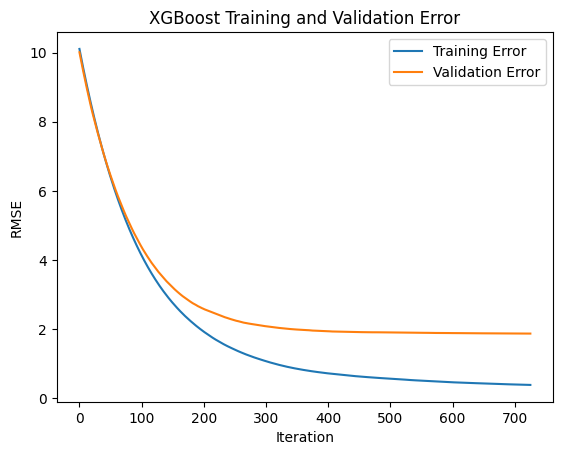

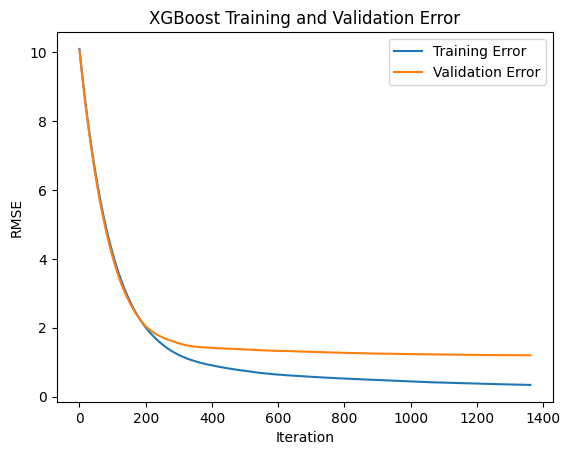

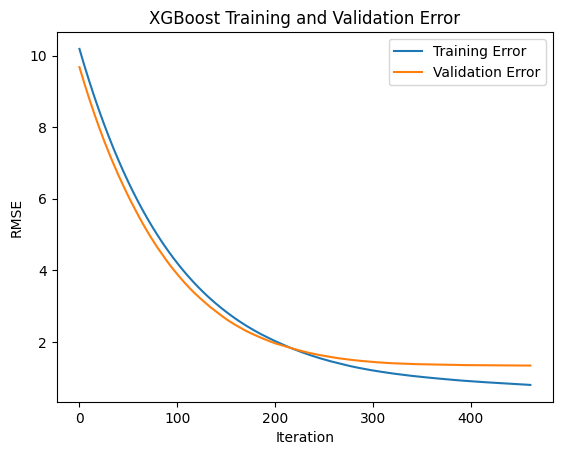

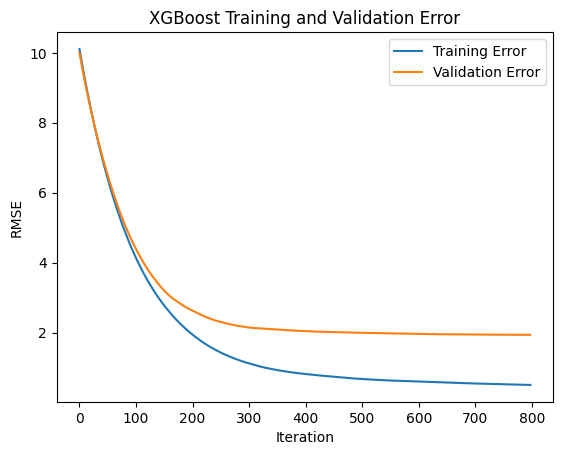

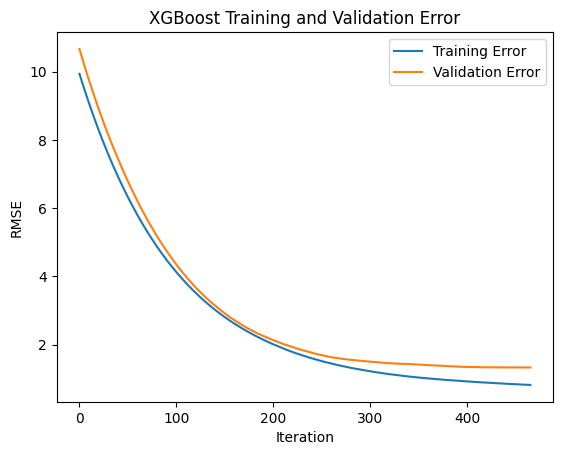

In [16]:
foldScores = xgbCV(xTrain, yTrain, xgbNewParams, N_FOLDS, MAX_ROUNDS)
cvResults = getAttributes(foldScores)

# Visualize training and validation error for each fold
for fold in foldScores:
    training_rounds = range(len(fold["train"]["rmse"]))
    plt.figure()
    plt.plot(training_rounds, fold["train"]["rmse"], label="Training Error")
    plt.plot(training_rounds, fold["validation"]["rmse"], label="Validation Error")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("XGBoost Training and Validation Error")
    plt.show()

In [17]:
# Train model with optimized params
xgbTuned = xgb.train(
    params=xgbNewParams,
    dtrain=dtrain,
    num_boost_round=300,
    maximize=False,
)

print(f"RMSE 5-fold CV: {cvResults[0]}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, xgbTuned.predict(dtrain), squared=False)}"
)

RMSE 5-fold CV: 1.5958113091363721
Training RMSE: 1.1796940415316368


#### Interpret Model


In [18]:
explainer = shap.Explainer(xgbTuned)
shapValues = explainer(xTrain)

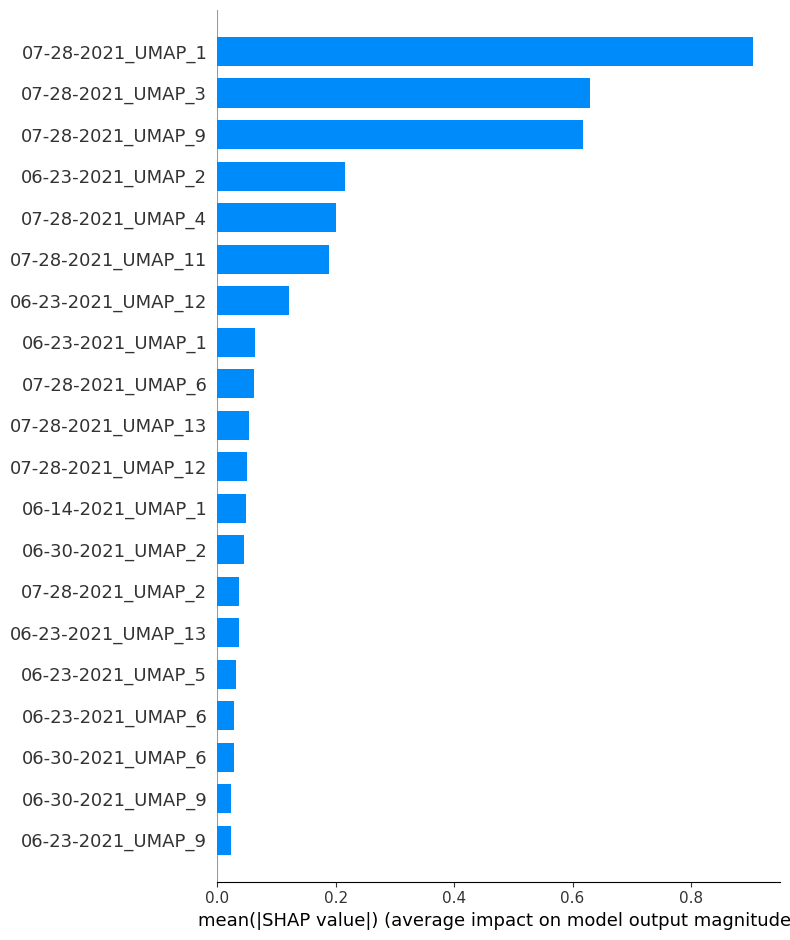

In [19]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[6:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


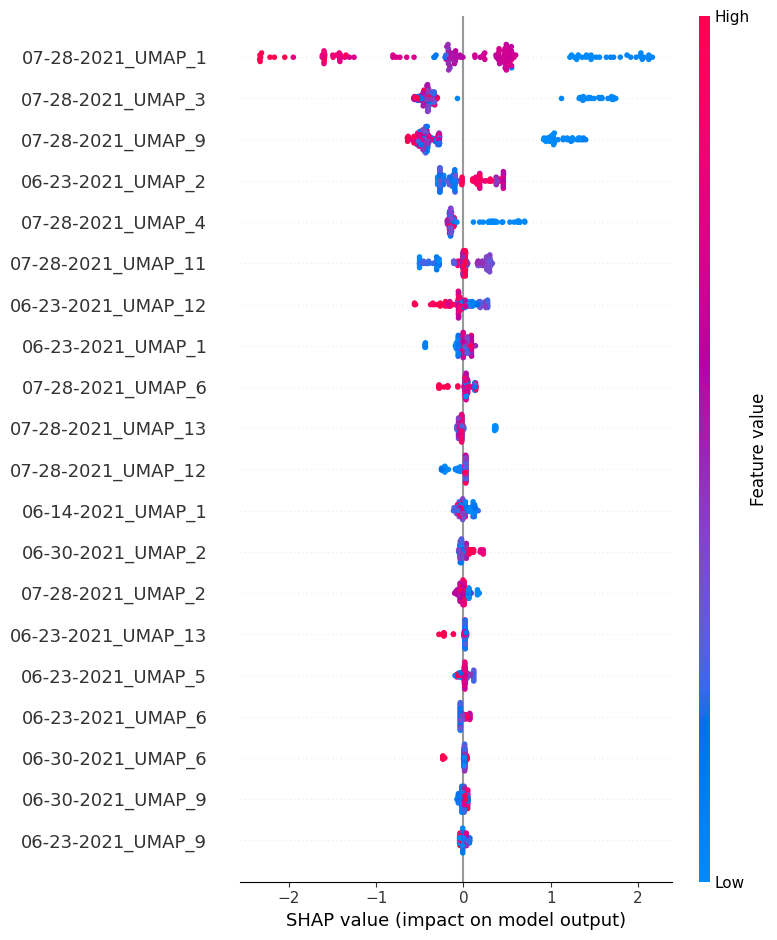

In [20]:
shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTrain.columns[6:])

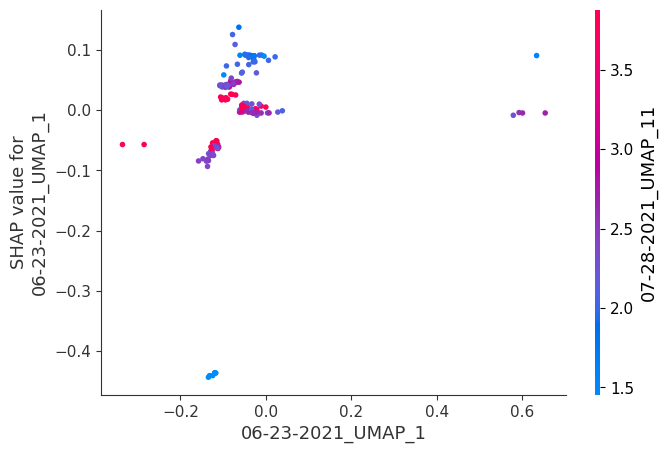

In [21]:
shap.dependence_plot(
    1, shapValues.values, xTrain, feature_names=dfWideTrain.columns[6:]
)

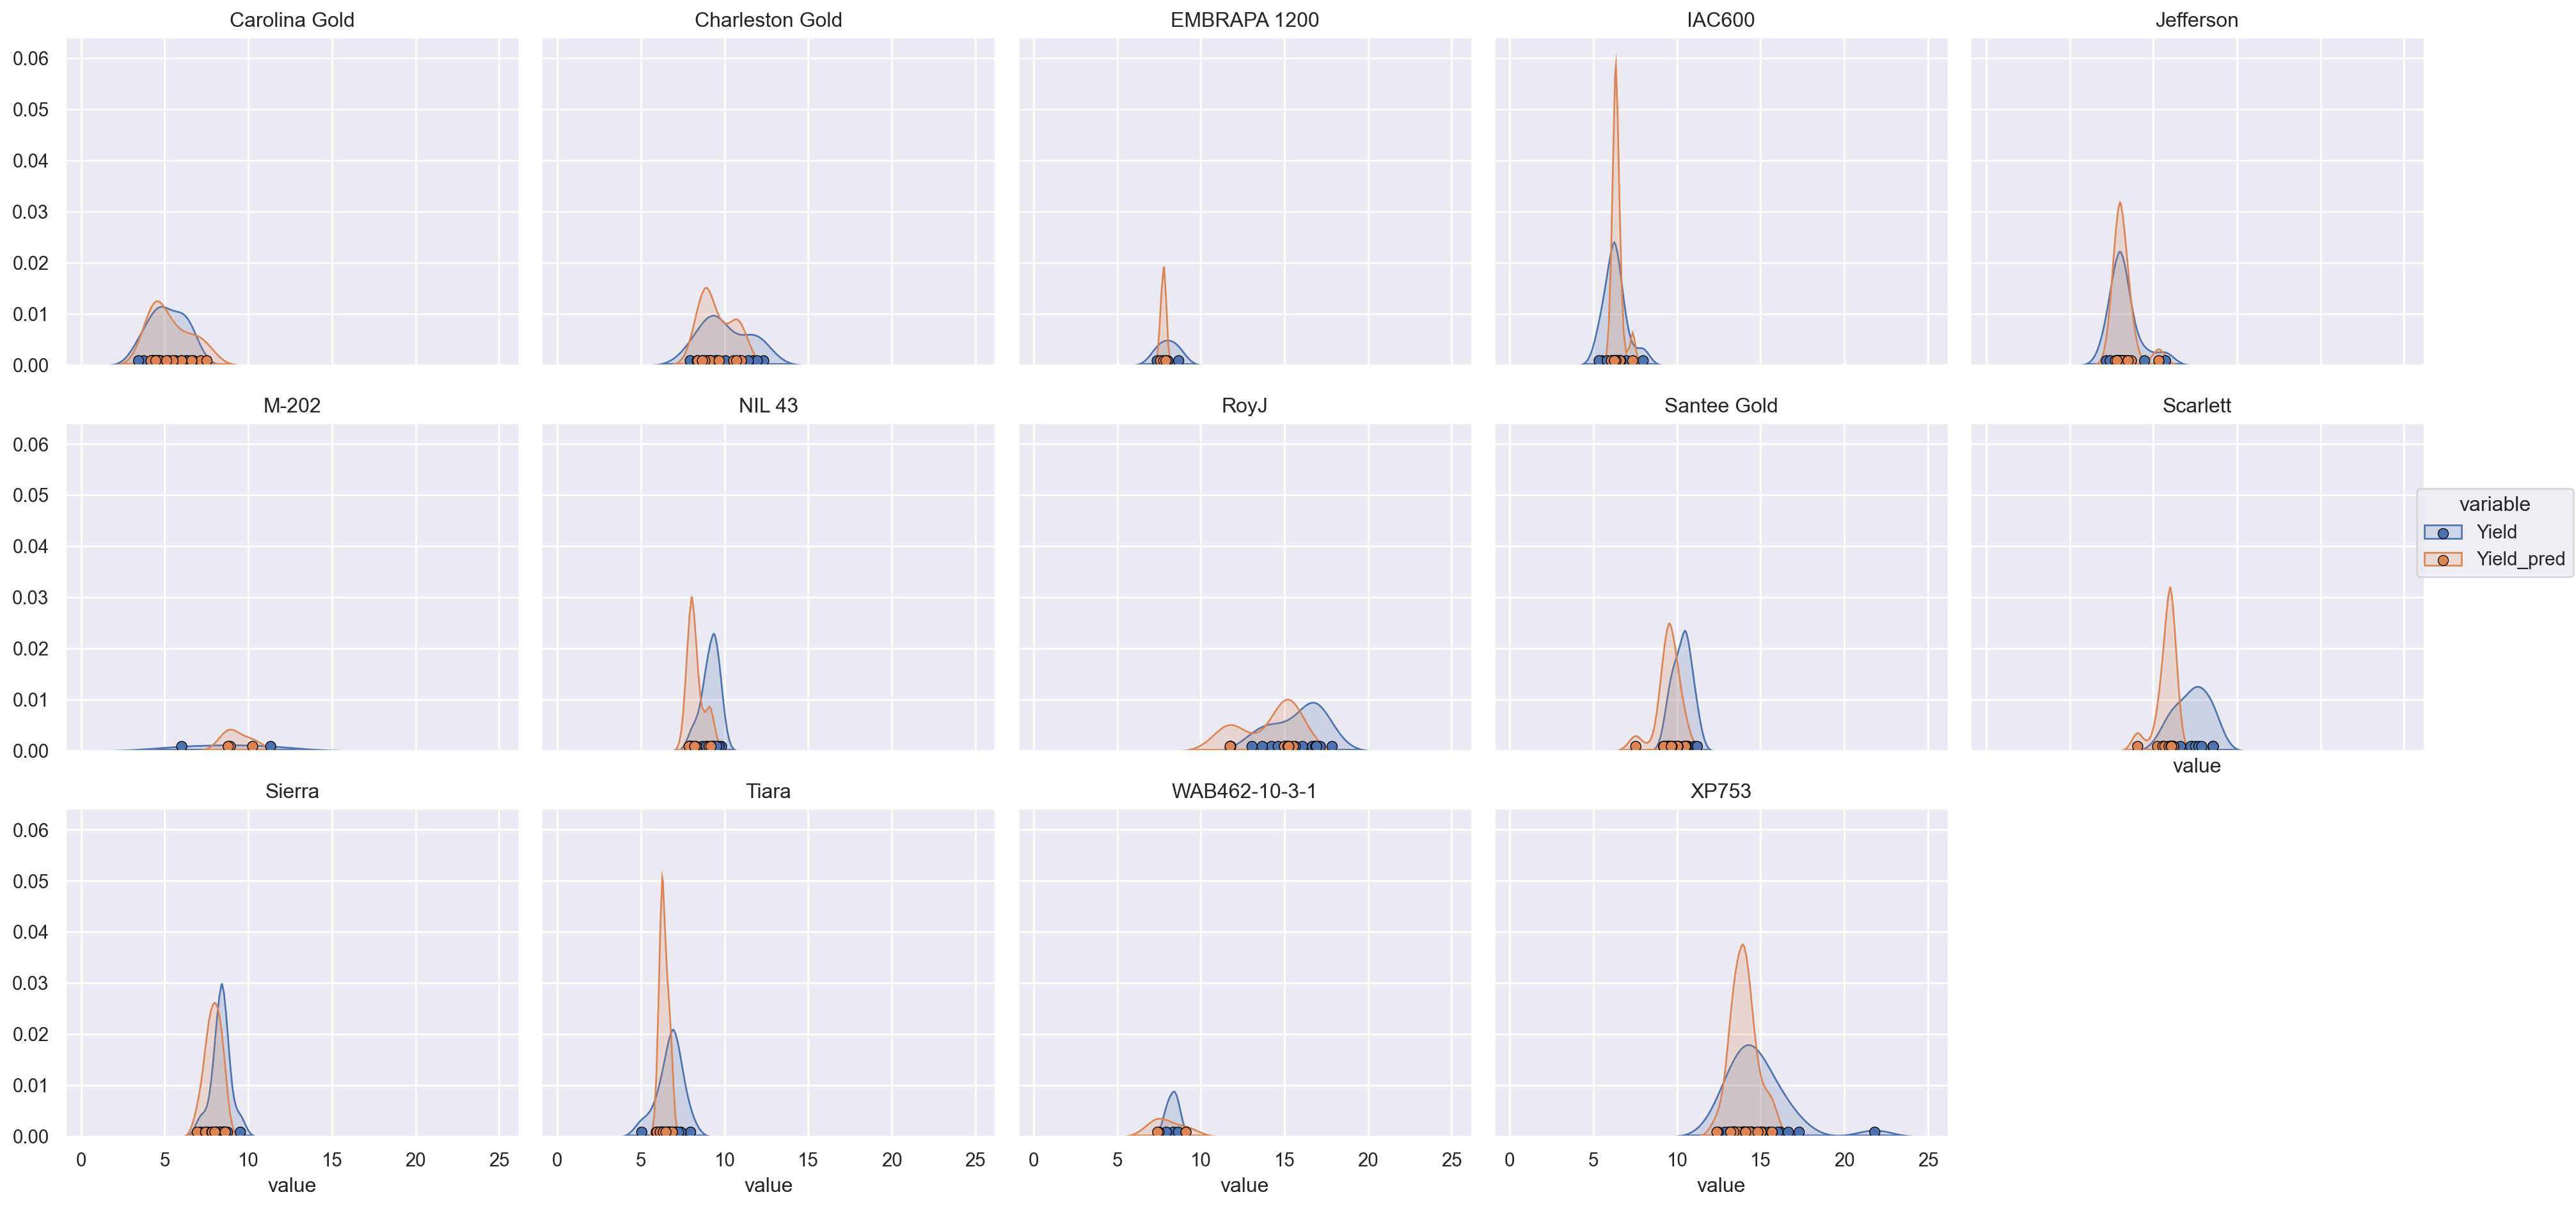

In [22]:
testDf = dfTrain.copy().reset_index(drop=True)
testDf["Yield_pred"] = xgbTuned.predict(dtrain)

temp = pd.melt(
    testDf,
    id_vars=testDf.columns[:-3],
    value_vars=["Yield", "Yield_pred"],
)
(
    so.Plot(
        temp,
        x="value",
    )
    .layout(size=(20, 10))
    .facet(
        # col="Experiment_Name",
        # order=[
        #     "Hybrid_XP753",
        #     "Inbred_Jeff + NIL",
        #     "Mini_Core",
        #     "Santee_Gold",
        #     "Tiara",
        # ],
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    # .share(x=False, y=False)
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.0008] * len(temp), color="variable")
    # .limit(y=(-0.001,0.06))
    # .scale(color=so.Nominal(order=sorted(temp["Rice_Cultivar"].unique())))
)

# del temp

#### Export Models


In [ ]:
# save tuned model
joblib.dump(xgbTuned, "Saved_Models/H2A3M2")